In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import cv2
%matplotlib inline

In [2]:
from glob import glob

In [3]:
import keras
import keras.backend as k

Using TensorFlow backend.


## Data Overview

In [4]:
trainImgDf=pd.read_csv('MURA-v1.1/train_image_paths.csv',header=None,names=['path'],dtype=str)
trainLabelDf=pd.read_csv('MURA-v1.1/train_labeled_studies.csv',header=None,names=['path','label'],dtype=str)
testImgDf=pd.read_csv('MURA-v1.1/valid_image_paths.csv',header=None,names=['path'],dtype=str)
testLabelDf=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv',header=None,names=['path','label'],dtype=str)


### there are 4 csv files dedicated to the store the path of the image and the binary label of each study. The label is either 0 or 1, indicating the study is abnormal or normal

In [5]:
# number of images
trainImgDf.shape

(36808, 1)

In [6]:
trainImgDf.head(10)

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
5,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
6,MURA-v1.1/train/XR_SHOULDER/patient00003/study...
7,MURA-v1.1/train/XR_SHOULDER/patient00003/study...
8,MURA-v1.1/train/XR_SHOULDER/patient00003/study...
9,MURA-v1.1/train/XR_SHOULDER/patient00004/study...


In [7]:
# number of labeled cases
trainLabelDf.shape

(13457, 2)

In the training set, the Mura data contains 13457 labeled cases, 36808 images. This indicates some cases may have more than 1 images.

In [8]:
# The binary output
trainLabelDf['label'].value_counts()

0    8280
1    5177
Name: label, dtype: int64

In [9]:
testImgDf.head(10)

,path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...
5,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...
6,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...
7,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...
8,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...
9,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...


In [10]:
# number of test images
testImgDf.shape

(3197, 1)

In [11]:
# number of cases
testLabelDf.shape

(1199, 2)

## adding additional columns by extrating information from the path for future analysis

In [12]:
trainLabelDf['part']=trainLabelDf['path'].apply(lambda x: str(x.split('/')[2])[3:])
trainLabelDf['patientNum']=trainLabelDf['path'].apply(lambda x: str(x.split('/')[3]))
trainLabelDf['studyNum']=trainLabelDf['path'].apply(lambda x: str(x.split('/')[4])[:6])
trainLabelDf['caseNum']=trainLabelDf[['patientNum','studyNum']].apply(lambda x: ''.join(x), axis=1)



testLabelDf['part']=testLabelDf['path'].apply(lambda x: str(x.split('/')[2])[3:])
testLabelDf['patientNum']=testLabelDf['path'].apply(lambda x: str(x.split('/')[3]))
testLabelDf['studyNum']=testLabelDf['path'].apply(lambda x: str(x.split('/')[4])[:6])
testLabelDf['caseNum']=testLabelDf[['patientNum','studyNum']].apply(lambda x: ''.join(x), axis=1)

In [13]:
trainLabelDf.head(10)

,path,label,part,patientNum,studyNum,caseNum
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,patient00001,study1,patient00001study1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,patient00002,study1,patient00002study1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,SHOULDER,patient00003,study1,patient00003study1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1,SHOULDER,patient00004,study1,patient00004study1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1,SHOULDER,patient00005,study1,patient00005study1
5,MURA-v1.1/train/XR_SHOULDER/patient00006/study...,1,SHOULDER,patient00006,study1,patient00006study1
6,MURA-v1.1/train/XR_SHOULDER/patient00007/study...,1,SHOULDER,patient00007,study1,patient00007study1
7,MURA-v1.1/train/XR_SHOULDER/patient00007/study...,0,SHOULDER,patient00007,study2,patient00007study2
8,MURA-v1.1/train/XR_SHOULDER/patient00008/study...,1,SHOULDER,patient00008,study1,patient00008study1
9,MURA-v1.1/train/XR_SHOULDER/patient00009/study...,1,SHOULDER,patient00009,study1,patient00009study1


In [14]:
testLabelDf.head(10)

,path,label,part,patientNum,studyNum,caseNum
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,patient11185,study1,patient11185study1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,WRIST,patient11186,study1,patient11186study1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1,WRIST,patient11186,study2,patient11186study2
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1,WRIST,patient11186,study3,patient11186study3
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1,WRIST,patient11187,study1,patient11187study1
5,MURA-v1.1/valid/XR_WRIST/patient11188/study1_p...,1,WRIST,patient11188,study1,patient11188study1
6,MURA-v1.1/valid/XR_WRIST/patient11189/study1_p...,1,WRIST,patient11189,study1,patient11189study1
7,MURA-v1.1/valid/XR_WRIST/patient11190/study1_p...,1,WRIST,patient11190,study1,patient11190study1
8,MURA-v1.1/valid/XR_WRIST/patient11191/study1_p...,1,WRIST,patient11191,study1,patient11191study1
9,MURA-v1.1/valid/XR_WRIST/patient11192/study1_p...,1,WRIST,patient11192,study1,patient11192study1


## the number of patient in the training/test set  

In [15]:
len(trainLabelDf['patientNum'].unique())

11184

In [16]:
len(testLabelDf['patientNum'].unique())

783

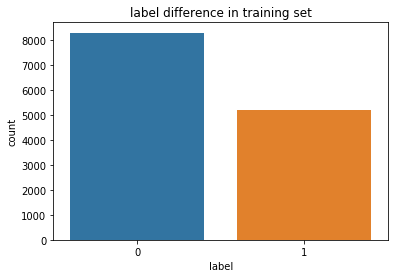

In [17]:
plt.title('label difference in training set')
sns.countplot(x=trainLabelDf['label'])

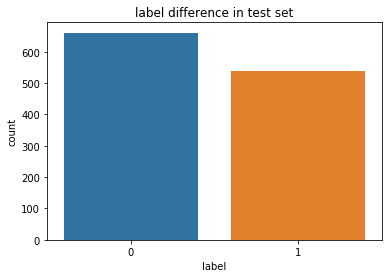

In [18]:
plt.title('label difference in test set')
sns.countplot(x=testLabelDf['label'])

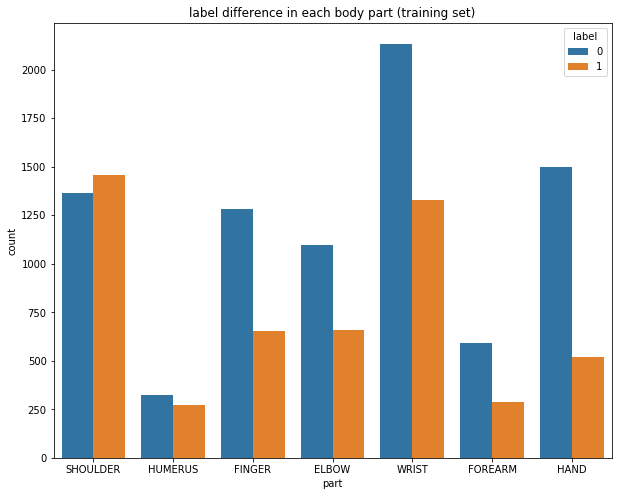

In [19]:
plt.figure(figsize=(10,8))
plt.title('label difference in each body part (training set)')
sns.countplot(data=trainLabelDf,x='part',hue='label')

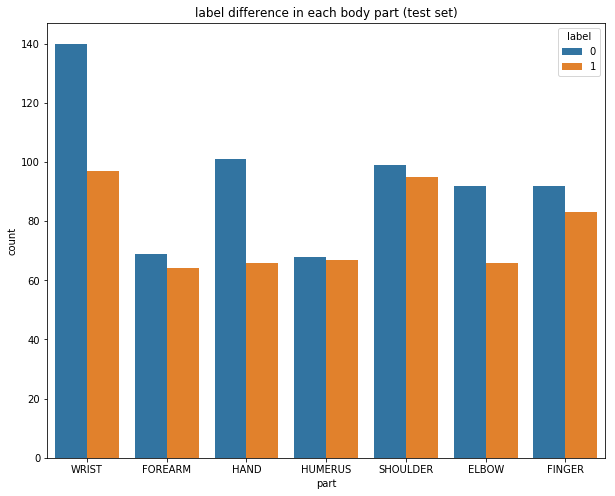

In [20]:
plt.figure(figsize=(10,8))
plt.title('label difference in each body part (test set)')
sns.countplot(data=testLabelDf,x='part',hue='label')

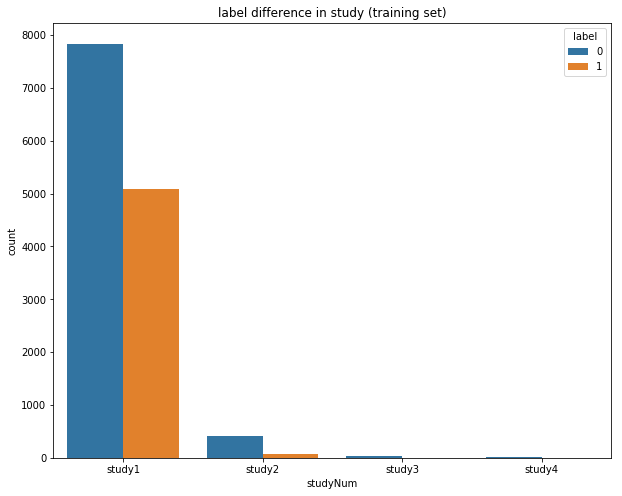

In [21]:
plt.figure(figsize=(10,8))
plt.title('label difference in study (training set)')
sns.countplot(data=trainLabelDf,x='studyNum',hue='label')

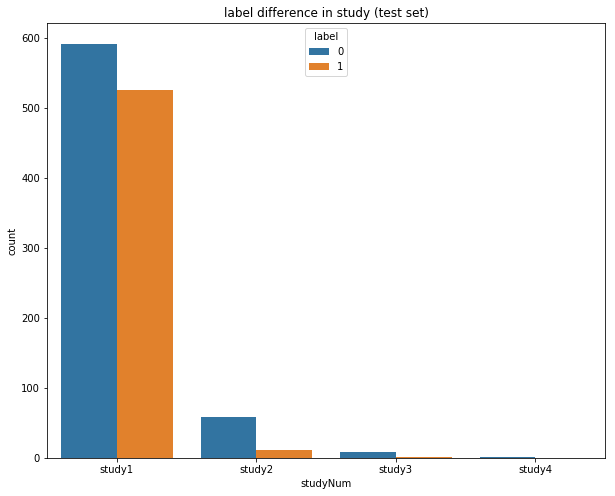

In [22]:
plt.figure(figsize=(10,8))
plt.title('label difference in study (test set)')
sns.countplot(data=testLabelDf,x='studyNum',hue='label')

### Plot a sample radiographs from training and validation set

(512, 380, 3) ['XR_SHOULDER', 'study1_positive']


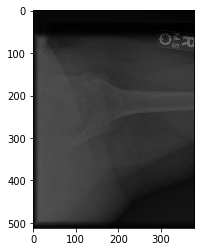

In [23]:
path=trainImgDf.values[0][0]
img=cv2.imread(path)
plt.imshow(img)
print(img.shape,path.split('/')[2:5:2])

(512, 405, 3) ['XR_HAND', 'study1_negative']


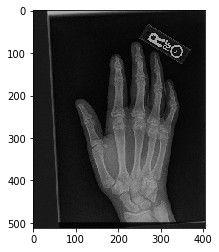

In [24]:
path=trainImgDf.values[-1][0]
img=cv2.imread(path)
plt.imshow(img)
print(img.shape,path.split('/')[2:5:2])

Patients might have multiple studies for a given study type, like a patient may have two studies for wrist, independent of each other. <br> Let's have a look at such cases, **NOTE** here study count = number of patients which have same number of studies

In [25]:
trainImgDf['part']=trainImgDf['path'].apply(lambda x: str(x.split('/')[2])[3:])
trainImgDf['patientNum']=trainImgDf['path'].apply(lambda x: str(x.split('/')[3]))
trainImgDf['studyNum']=trainImgDf['path'].apply(lambda x: str(x.split('/')[4])[:6])
trainImgDf['caseNum']=trainImgDf[['patientNum','studyNum']].apply(lambda x: ''.join(x), axis=1)



testImgDf['part']=testImgDf['path'].apply(lambda x: str(x.split('/')[2])[3:])
testImgDf['patientNum']=testImgDf['path'].apply(lambda x: str(x.split('/')[3]))
testImgDf['studyNum']=testImgDf['path'].apply(lambda x: str(x.split('/')[4])[:6])
testImgDf['caseNum']=testImgDf[['patientNum','studyNum']].apply(lambda x: ''.join(x), axis=1)

In [26]:
trainImgDf.head()

,path,part,patientNum,studyNum,caseNum
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,patient00001study1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,patient00001study1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,SHOULDER,patient00001,study1,patient00001study1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,patient00002,study1,patient00002study1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,SHOULDER,patient00002,study1,patient00002study1


In [27]:
trainImgDf['part'].value_counts()

WRIST       9752
SHOULDER    8379
HAND        5543
FINGER      5106
ELBOW       4931
FOREARM     1825
HUMERUS     1272
Name: part, dtype: int64

In [28]:
testImgDf.head()

,path,part,patientNum,studyNum,caseNum
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,patient11185study1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,patient11185study1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,patient11185study1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,WRIST,patient11185,study1,patient11185study1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,WRIST,patient11186,study1,patient11186study1


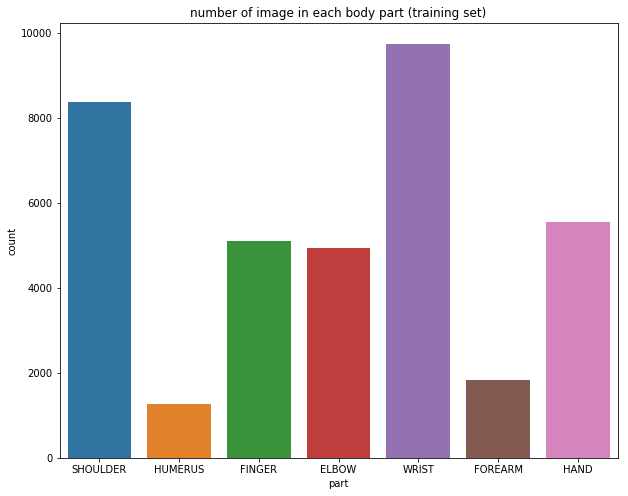

In [29]:
plt.figure(figsize=(10,8))
plt.title('number of image in each body part (training set)')
sns.countplot(data=trainImgDf,x='part')

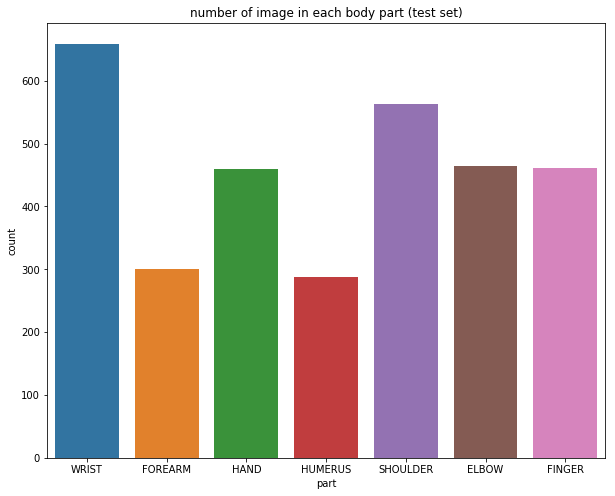

In [30]:
plt.figure(figsize=(10,8))
plt.title('number of image in each body part (test set)')
sns.countplot(data=testImgDf,x='part')

### within each body type, we display the numeber of images per study cases 

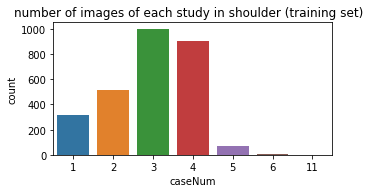

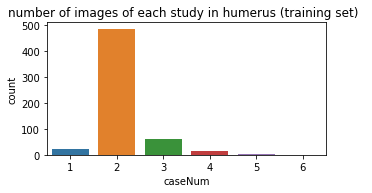

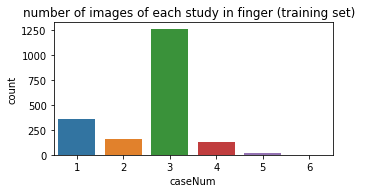

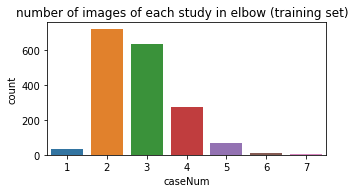

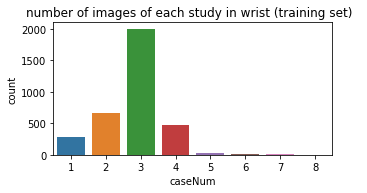

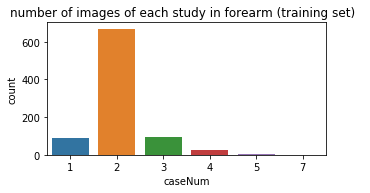

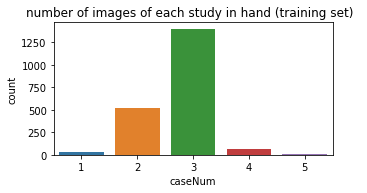

In [31]:
bodyType = trainImgDf['part'].unique()
for idx,body in enumerate(bodyType):
    plt.figure(figsize=(5,20))
    ax = plt.subplot(711+idx)
    bodyCase = trainImgDf[trainImgDf['part'] == body]
    plt.title('number of images of each study in %s (training set)  ' % body.lower())
    sns.countplot(bodyCase['caseNum'].value_counts())


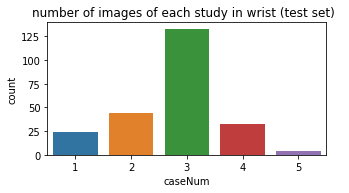

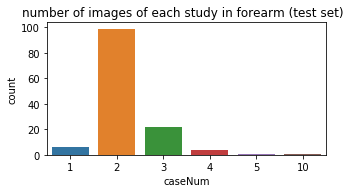

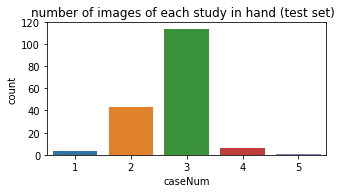

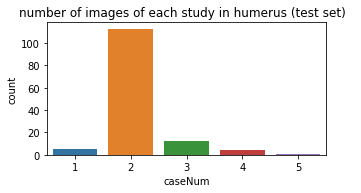

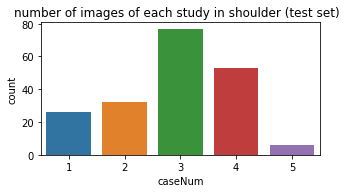

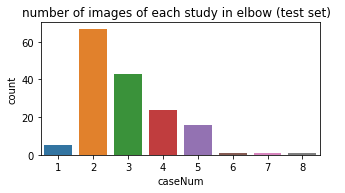

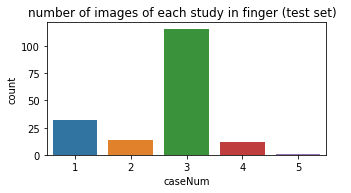

In [32]:
bodyType = testImgDf['part'].unique()
for idx,body in enumerate(bodyType):
    plt.figure(figsize=(5,20))
    ax = plt.subplot(711+idx)
    bodyCase = testImgDf[testImgDf['part'] == body]
    plt.title('number of images of each study in %s (test set)  ' % body.lower())
    sns.countplot(bodyCase['caseNum'].value_counts())

most of the study cases have more than one images, which will make the predication more difficult. The spread of image is related to the body type.

## Train CNN for the images of hand

##### Extract only the dataframe for hands

In [33]:
trainLabelDf['label'][0:5]

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: object

In [34]:
# extract part of 'HAND' for training

train_hand_img = trainImgDf[trainImgDf['part'] == 'HAND']
train_hand_label = trainLabelDf[trainLabelDf['part'] == 'HAND']
test_hand_img = testImgDf[testImgDf['part'] == 'HAND']
test_hand_label = testLabelDf[testLabelDf['part'] == 'HAND']

In [35]:
train_hand_label.count()

path          2018
label         2018
part          2018
patientNum    2018
studyNum      2018
caseNum       2018
dtype: int64

### Prepocessing 

   1. Resizing the image with same resolution (use one channel)
   2. Normalization (in Keras)
   3. Taking the average of the image intensities within one case for training.
   

###### Output one color channel.

(512, 405)

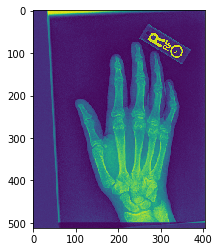

In [36]:
Path=trainImgDf.values[-1][0]
img=cv2.imread(Path)
plt.imshow(img[:,:,2])    #the color is not important to distinguish
img[:,:,2].shape   ## just a test to make sure they give same x-ray images (independant of color)

In [102]:
## function to resize and normalize the image

def resize_and_normalization(Path):
    img=cv2.imread(Path)
    
    # Use one channel (or grayscale)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Sizing down the resolution. (224, 224) is used in the article
    img=cv2.resize(img,(150,150))
    
    # 
    img=np.array(img)
   # img=img
    
    return img

In [103]:
resize_and_normalization(trainLabelDf['path'][1]+'image1.png').shape


(150, 150)

In [104]:
train_hand_label

,path,label,part,patientNum,studyNum,caseNum,avgpath
11439,MURA-v1.1/train/XR_HAND/patient09734/study1_po...,1,HAND,patient09734,study1,patient09734study1,MURA-v1.1/train/XR_HAND/patient09734/study1_po...
11440,MURA-v1.1/train/XR_HAND/patient09735/study1_po...,1,HAND,patient09735,study1,patient09735study1,MURA-v1.1/train/XR_HAND/patient09735/study1_po...
11441,MURA-v1.1/train/XR_HAND/patient07365/study1_po...,1,HAND,patient07365,study1,patient07365study1,MURA-v1.1/train/XR_HAND/patient07365/study1_po...
11442,MURA-v1.1/train/XR_HAND/patient09736/study1_po...,1,HAND,patient09736,study1,patient09736study1,MURA-v1.1/train/XR_HAND/patient09736/study1_po...
11443,MURA-v1.1/train/XR_HAND/patient09737/study1_po...,1,HAND,patient09737,study1,patient09737study1,MURA-v1.1/train/XR_HAND/patient09737/study1_po...
11444,MURA-v1.1/train/XR_HAND/patient08710/study1_po...,1,HAND,patient08710,study1,patient08710study1,MURA-v1.1/train/XR_HAND/patient08710/study1_po...
11445,MURA-v1.1/train/XR_HAND/patient09738/study1_po...,1,HAND,patient09738,study1,patient09738study1,MURA-v1.1/train/XR_HAND/patient09738/study1_po...
11446,MURA-v1.1/train/XR_HAND/patient09739/study1_po...,1,HAND,patient09739,study1,patient09739study1,MURA-v1.1/train/XR_HAND/patient09739/study1_po...
11447,MURA-v1.1/train/XR_HAND/patient09740/study1_po...,1,HAND,patient09740,study1,patient09740study1,MURA-v1.1/train/XR_HAND/patient09740/study1_po...
11448,MURA-v1.1/train/XR_HAND/patient09740/study2_ne...,0,HAND,patient09740,study2,patient09740study2,MURA-v1.1/train/XR_HAND/patient09740/study2_ne...


##### Average the images and save it into one file

In [105]:
for folder in train_hand_label['path']:
    ii = 0
    img_sum = np.zeros((150, 150))
    pic = glob(folder+'*.png')
    for filename in pic:
        im = resize_and_normalization(filename)
        img_sum += im 
        ii += 1
   # m = Image.fromarray(rescaled)
    img_average = img_sum / ii
    cv2.imwrite(folder + "img_average.png", img_average)


   # img_average.save("mean_img.png",img_average)
   # trainLabelDf['path'] =  trainLabelDf['path'] + 'mean_img.png'                          
#os.listdir(trainLabelDf['path'][0])


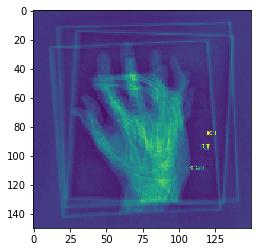

In [109]:
img=cv2.imread(train_hand_label['path'][11439] + 'img_average.png',0)
plt.imshow(img)

In [110]:
img_average.shape

(150, 150)

In [111]:
train_hand_label['path'][11439] + 'img_average.png'

'MURA-v1.1/train/XR_HAND/patient09734/study1_positive/img_average.png'

In [112]:
train_hand_label['avgpath']=train_hand_label['path'].apply(lambda x: x+'img_average.png')
test_hand_label['avgpath']=test_hand_label['path'].apply(lambda x: x+'img_average.png')

## add path + img_average.png to get the path for average image of each cases

C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [113]:
train_hand_label.head()

,path,label,part,patientNum,studyNum,caseNum,avgpath
11439,MURA-v1.1/train/XR_HAND/patient09734/study1_po...,1,HAND,patient09734,study1,patient09734study1,MURA-v1.1/train/XR_HAND/patient09734/study1_po...
11440,MURA-v1.1/train/XR_HAND/patient09735/study1_po...,1,HAND,patient09735,study1,patient09735study1,MURA-v1.1/train/XR_HAND/patient09735/study1_po...
11441,MURA-v1.1/train/XR_HAND/patient07365/study1_po...,1,HAND,patient07365,study1,patient07365study1,MURA-v1.1/train/XR_HAND/patient07365/study1_po...
11442,MURA-v1.1/train/XR_HAND/patient09736/study1_po...,1,HAND,patient09736,study1,patient09736study1,MURA-v1.1/train/XR_HAND/patient09736/study1_po...
11443,MURA-v1.1/train/XR_HAND/patient09737/study1_po...,1,HAND,patient09737,study1,patient09737study1,MURA-v1.1/train/XR_HAND/patient09737/study1_po...


In [114]:
# perform same operation for test dataset

for folder in test_hand_label['path']:
    ii = 0
    img_sum = np.zeros((150, 150))
    for filename in os.listdir(folder):
        im = resize_and_normalization(folder + filename)
        img_sum += im 
        ii += 1
   # m = Image.fromarray(rescaled)
    img_average = img_sum / ii
    cv2.imwrite(folder + "img_average.png", img_average)


### Building CNN using Keras

In [115]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [171]:
## image size (sizing down the original image)
IMG_SIZE=(150,150)

In [203]:
## CNN architecture (variation of LeNet)
input_shape = (150, 150, 1)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

##### Data Augmentation

In [204]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    rotation_range=25,
    fill_mode='nearest',
)

In [205]:
batch_size = 16

In [206]:

train_generator = datagen.flow_from_dataframe(
    train_hand_label,x_col='avgpath',
    y_col = 'label',
    target_size= IMG_SIZE,
    color_mode = 'grayscale',
    batch_size= 16)


test_generator = datagen.flow_from_dataframe(
    test_hand_label,x_col='avgpath',
    y_col = 'label',
    target_size= IMG_SIZE,
    color_mode = 'grayscale',
    batch_size= 16)

Found 2018 validated image filenames belonging to 2 classes.
Found 167 validated image filenames belonging to 2 classes.


In [ ]:
# need to be changed
epochs = 50
nb_train_samples = train_hand_label['label'].count()
nb_test_samples = test_hand_label['label'].count()
model.fit_generator(train_generator, 
                      steps_per_epoch=nb_train_samples // batch_size,
                    epochs=epochs,
                   validation_data=test_generator,
                      validation_steps=nb_test_samples // batch_size)

Epoch 1/50
 61/126 [=============>................] - ETA: 18s - loss: 0.6187 - acc: 0.7203